# Preprocessing Pipeline Visualization

This notebook demonstrates the complete preprocessing pipeline for CT volumes:
1. Load 3D volume
2. Normalize with z-score
3. Resample to target resolution
4. Extract 2D patches (224x224)
5. Convert to RGB (3-channel)

Each step includes visualization to inspect the transformations.

## Setup and Imports

In [6]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import tifffile

# Add src to path for imports
sys.path.insert(0, str(Path.cwd().parent / "src"))

from preprocessing import (
    normalize_volume_zscore,
    resample_volume,
    resample_volume_gpu,
    extract_patches,
    grayscale_to_rgb,
)

# Configure matplotlib
plt.rcParams["figure.figsize"] = (15, 5)
plt.rcParams["figure.dpi"] = 100

print("✓ Imports successful")

✓ Imports successful


## Helper Functions for Visualization

In [2]:
def visualize_volume_slices(volume, title="Volume", num_slices=5, cmap="gray"):
    """
    Visualize multiple slices from a 3D volume.
    """
    depth = volume.shape[0]
    slice_indices = np.linspace(0, depth - 1, num_slices, dtype=int)

    fig, axes = plt.subplots(1, num_slices, figsize=(15, 3))
    fig.suptitle(f"{title} - Shape: {volume.shape}", fontsize=14, fontweight="bold")

    for i, (ax, idx) in enumerate(zip(axes, slice_indices)):
        ax.imshow(volume[idx], cmap=cmap, aspect="auto")
        ax.set_title(f"Slice {idx}/{depth - 1}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

    # Print statistics
    print("Statistics:")
    print(f"  Shape: {volume.shape}")
    print(f"  Dtype: {volume.dtype}")
    print(f"  Min: {volume.min():.2f}, Max: {volume.max():.2f}")
    print(f"  Mean: {volume.mean():.2f}, Std: {volume.std():.2f}")
    print()


def visualize_patches(patches, title="Patches", num_patches=12, cmap="gray"):
    """
    Visualize a grid of patches.
    """
    num_patches = min(num_patches, patches.shape[0])
    rows = 3
    cols = num_patches // rows

    fig, axes = plt.subplots(rows, cols, figsize=(15, 8))
    fig.suptitle(
        f"{title} - Total: {patches.shape[0]} patches", fontsize=14, fontweight="bold"
    )

    for i, ax in enumerate(axes.flat):
        if i < num_patches:
            # Handle both 2D and 3D patches
            if patches[i].ndim == 2:
                img = patches[i]
            elif patches[i].ndim == 3 and patches[i].shape[0] == 1:
                img = patches[i, 0]  # 2D patch with depth=1
            else:
                img = patches[i, patches[i].shape[0] // 2]  # Middle slice of 3D patch

            ax.imshow(img, cmap=cmap, aspect="auto")
            ax.set_title(f"Patch {i}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

    print("Patch Statistics:")
    print(f"  Shape: {patches.shape}")
    print(f"  Dtype: {patches.dtype}")
    print(f"  Min: {patches.min():.2f}, Max: {patches.max():.2f}")
    print(f"  Mean: {patches.mean():.2f}, Std: {patches.std():.2f}")
    print()


def visualize_rgb_patches(rgb_patches, title="RGB Patches", num_patches=12):
    """
    Visualize RGB patches (3 channels).
    """
    num_patches = min(num_patches, rgb_patches.shape[0])
    rows = 3
    cols = num_patches // rows

    fig, axes = plt.subplots(rows, cols, figsize=(15, 8))
    fig.suptitle(
        f"{title} - Total: {rgb_patches.shape[0]} patches",
        fontsize=14,
        fontweight="bold",
    )

    for i, ax in enumerate(axes.flat):
        if i < num_patches:
            # Extract single channel for display (all 3 are identical)
            # Shape: (3, H, W) -> take channel 0
            img = rgb_patches[i, 0]

            ax.imshow(img, cmap="gray", aspect="auto")
            ax.set_title(f"Patch {i} (Ch 0)")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

    print("RGB Patch Statistics:")
    print(f"  Shape: {rgb_patches.shape}")
    print(f"  Dtype: {rgb_patches.dtype}")
    print(
        f"  Channels are identical: {np.array_equal(rgb_patches[:, 0], rgb_patches[:, 1])}"
    )
    print()


print("✓ Helper functions defined")

✓ Helper functions defined


## Step 1: Load 3D Volume

Load a CT volume from disk. For testing, we'll create a synthetic volume if no real data is available.

✓ Loaded volume from K:\499-ProjectData\2025\P25-0048_Thyroid_Recurrence\04-Processed_Datasets\split_cleared_dataset\002_B05.20964B.tif


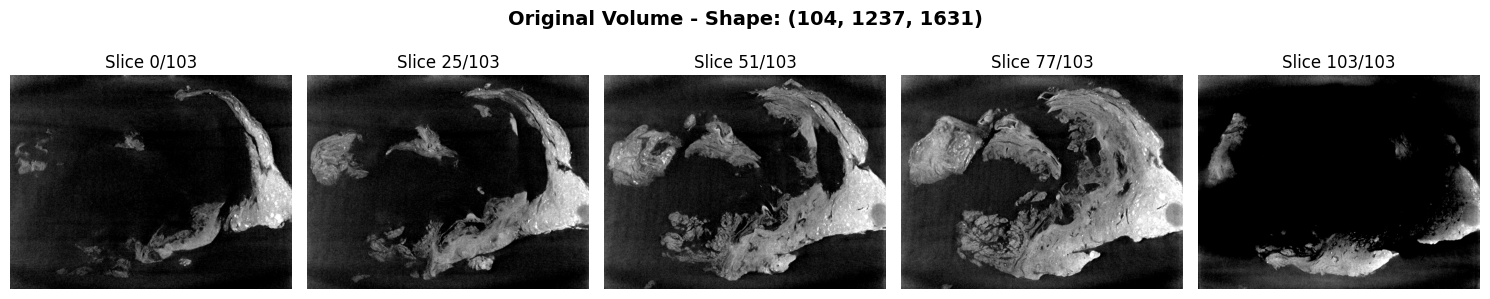

Statistics:
  Shape: (104, 1237, 1631)
  Dtype: float32
  Min: 0.00, Max: 255.00
  Mean: 58.31, Std: 58.81



In [3]:
# Option 1: Load real CT data (modify path as needed)
# Uncomment and modify the path below to load your actual data
data_path = Path(
    "K:/499-ProjectData/2025/P25-0048_Thyroid_Recurrence/04-Processed_Datasets/split_cleared_dataset"
)
volume_file = data_path / "002_B05.20964B.tif"
if volume_file.exists():
    volume = tifffile.imread(volume_file).astype(np.float32)
    print(f"✓ Loaded volume from {volume_file}")
else:
    print(f"File not found: {volume_file}")
    volume = None

# Option 2: Create synthetic volume for testing
# print("Creating synthetic CT volume for demonstration...")
# np.random.seed(42)

# # Simulate a CT volume with typical characteristics
# depth, height, width = 100, 512, 512
# volume = np.random.randn(depth, height, width).astype(np.float32) * 200 + 1000

# # Add some structure (simulated organs/tissues)
# # Create a bright region (bone)
# volume[40:60, 200:300, 200:300] += 500

# # Create a darker region (soft tissue)
# volume[30:70, 150:180, 350:400] -= 300

# print(f"✓ Created synthetic volume")

# Visualize original volume
visualize_volume_slices(volume, title="Original Volume", num_slices=5)

## Step 2: Normalize Volume (Z-Score)

Apply z-score normalization to standardize the intensity values.

✓ Volume normalized


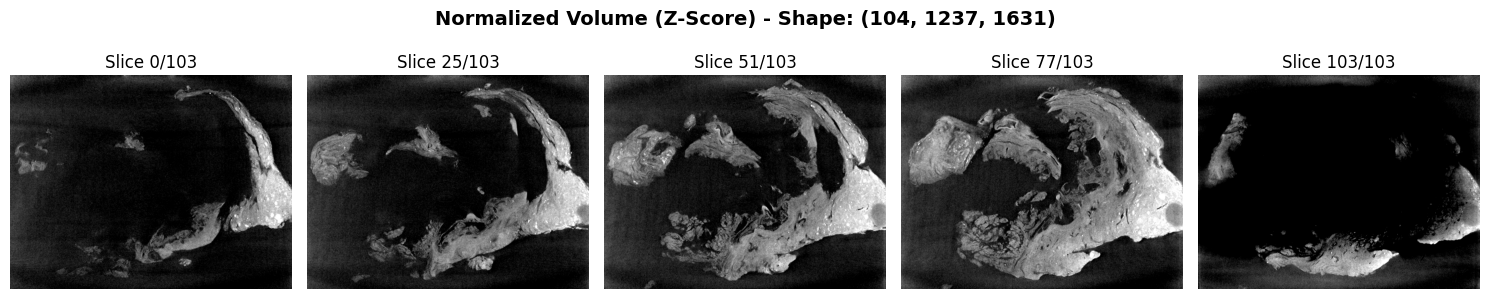

Statistics:
  Shape: (104, 1237, 1631)
  Dtype: float32
  Min: -0.99, Max: 3.34
  Mean: 0.00, Std: 1.00



In [4]:
# Normalize the volume
volume_normalized = normalize_volume_zscore(volume, dtype=np.float32)

print("✓ Volume normalized")

# Visualize normalized volume
visualize_volume_slices(
    volume_normalized, title="Normalized Volume (Z-Score)", num_slices=5
)

## Step 3: Resample Volume

Resample the volume to a target resolution. For CT scans, we often want isotropic spacing.

In [11]:
import numpy as np

# Define original and target spacing
# Typical CT: thicker slices (e.g., 2.5mm), thinner in-plane (e.g., 0.5mm)
original_spacing = (0.015303, 0.015303, 0.015303)  # (depth, height, width) in mm
target_spacing = (0.012, 0.012, 0.012)  # Isotropic 1mm spacing

print(f"Resampling from {original_spacing} to {target_spacing} mm...")

cupy_accelerated=True

if cupy_accelerated:
    import torch
    volume_normalized = torch.rand((200, 1000, 1000))
    volume_mb = volume_normalized.element_size() * volume_normalized.nelement() / (1024 ** 2)
    print(f"Volume size in memory: {volume_mb:.2f} MB")
    volume_resampled = resample_volume_gpu(
        volume_normalized,
        original_spacing=original_spacing,
        target_spacing=target_spacing,
        order=3,  # Cubic interpolation
        preserve_range=True,
    )


# Resample the normalized volume
if not cupy_accelerated:
    volume_resampled = resample_volume(
        volume_normalized,
        original_spacing=original_spacing,
        target_spacing=target_spacing,
        order=3,  # Cubic interpolation
        preserve_range=True,
    )

print("✓ Volume resampled")
print(f"  Original shape: {volume_normalized.shape}")
print(f"  Resampled shape: {volume_resampled.shape}")
print()

# Visualize resampled volume
visualize_volume_slices(
    volume_resampled,
    title=f"Resampled Volume ({np.unique(target_spacing)} isotropic)",
    num_slices=5,
)

Resampling from (0.015303, 0.015303, 0.015303) to (0.012, 0.012, 0.012) mm...
Volume size in memory: 762.94 MB


CUDARuntimeError: cudaErrorLaunchTimeout: the launch timed out and was terminated

## Step 4: Extract 2D Patches (224x224)

Extract 2D patches of size 224x224 from the resampled volume.

Extracting 2D patches of size (1, 224, 224) with stride (1, 224, 224)...
✓ Extracted 10640 patches
  Patch shape: (10640, 1, 224, 224)
  Positions shape: (10640, 3)



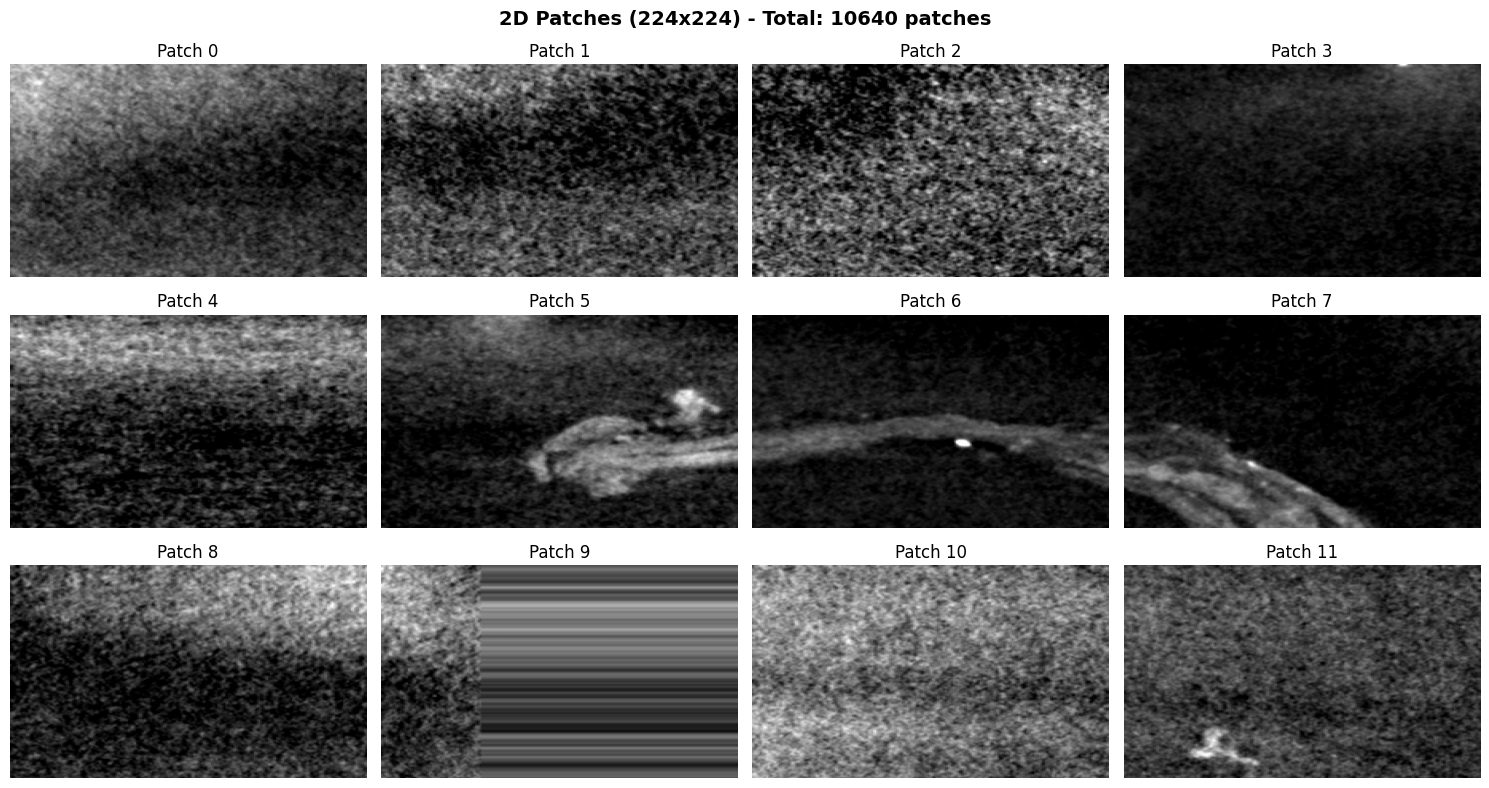

Patch Statistics:
  Shape: (10640, 1, 224, 224)
  Dtype: float32
  Min: -0.99, Max: 3.34
  Mean: -0.05, Std: 0.98



In [7]:
# Extract 2D patches with overlap
patch_size = (1, 224, 224)  # depth=1 for 2D patches
stride = (1, 224, 224)  # Non-overlapping patches

print(f"Extracting 2D patches of size {patch_size} with stride {stride}...")

patches, positions = extract_patches(
    volume_resampled,
    patch_size=patch_size,
    stride=stride,
    padding_mode="edge",
    padding_value=0.0,
    drop_incomplete=False,
)

print(f"✓ Extracted {patches.shape[0]} patches")
print(f"  Patch shape: {patches.shape}")
print(f"  Positions shape: {positions.shape}")
print()

# Visualize patches
visualize_patches(patches, title="2D Patches (224x224)", num_patches=12)

## Step 5: Convert to RGB (3-Channel)

Stack the grayscale channel 3 times to create RGB-compatible input for the UNI encoder.

In [ ]:
# Remove the depth dimension since it's 1 for 2D patches
# Shape: (N, 1, H, W) -> (N, H, W)
patches_2d = patches[:, 0, :, :]

print("Preparing patches for RGB conversion...")
print(f"  Input shape: {patches_2d.shape}")

# Convert to RGB
rgb_patches = grayscale_to_rgb(patches_2d)

print("✓ Converted to RGB")
print(f"  RGB shape: {rgb_patches.shape}")
print(
    f"  Format: (N, C, H, W) = ({rgb_patches.shape[0]}, {rgb_patches.shape[1]}, {rgb_patches.shape[2]}, {rgb_patches.shape[3]})"
)
print()

# Visualize RGB patches
visualize_rgb_patches(rgb_patches, title="RGB Patches (3-Channel)", num_patches=12)

## Step 6: Verify Channel Replication

Verify that all three channels contain identical data.

In [ ]:
# Pick a random patch to visualize all 3 channels
patch_idx = np.random.randint(0, rgb_patches.shape[0])
sample_patch = rgb_patches[patch_idx]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle(f"RGB Channels for Patch {patch_idx}", fontsize=14, fontweight="bold")

for i, (ax, channel_name) in enumerate(zip(axes, ["Red", "Green", "Blue"])):
    ax.imshow(sample_patch[i], cmap="gray", aspect="auto")
    ax.set_title(f"{channel_name} Channel")
    ax.axis("off")

plt.tight_layout()
plt.show()

# Verify channels are identical
print("Channel Verification:")
print(f"  Red == Green: {np.array_equal(sample_patch[0], sample_patch[1])}")
print(f"  Green == Blue: {np.array_equal(sample_patch[1], sample_patch[2])}")
print(f"  Red == Blue: {np.array_equal(sample_patch[0], sample_patch[2])}")

## Summary

Complete preprocessing pipeline summary:

In [ ]:
print("=" * 80)
print("PREPROCESSING PIPELINE SUMMARY")
print("=" * 80)
print()
print("1. Original Volume:")
print(f"   Shape: {volume.shape}")
print(f"   Dtype: {volume.dtype}")
print(f"   Range: [{volume.min():.2f}, {volume.max():.2f}]")
print()
print("2. Normalized Volume:")
print(f"   Shape: {volume_normalized.shape}")
print(f"   Mean: {volume_normalized.mean():.6f}, Std: {volume_normalized.std():.6f}")
print()
print("3. Resampled Volume:")
print(f"   Shape: {volume_resampled.shape}")
print(f"   Spacing: {original_spacing} → {target_spacing} mm")
print()
print("4. Extracted Patches:")
print(f"   Shape: {patches.shape}")
print(f"   Patch size: {patch_size}")
print(f"   Stride: {stride}")
print(f"   Total patches: {patches.shape[0]}")
print()
print("5. RGB Patches (Final):")
print(f"   Shape: {rgb_patches.shape}")
print("   Format: (Batch, Channels, Height, Width)")
print("   Ready for UNI encoder: ✓")
print()
print("=" * 80)

## Optional: Save Preprocessed Data

Save the preprocessed patches for later use.

In [ ]:
# Uncomment to save the preprocessed patches
# output_dir = Path("../data/preprocessed")
# output_dir.mkdir(exist_ok=True, parents=True)

# # Save as numpy array
# np.save(output_dir / "rgb_patches.npy", rgb_patches)
# np.save(output_dir / "positions.npy", positions)

# print(f"✓ Saved preprocessed data to {output_dir}")

print("Notebook execution complete!")